In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from brian2 import start_scope, prefs, run
from brian2 import PoissonGroup, NeuronGroup, Synapses, StateMonitor, SpikeMonitor, TimedArray
from brian2 import ms, mV, Hz

# Import libraries from outside folder
import sys
sys.path.append('../lib/')

import traces_lib, opencv_lib

/home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


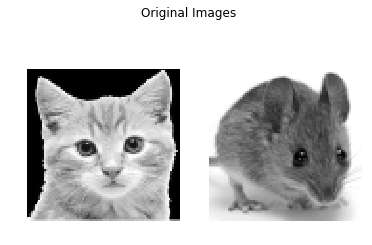

In [2]:
# Load raw images
# img1 = (mpimg.imread('img/cat4.png')[:,:,0] > 0.5).astype(int)
# img2 = (mpimg.imread('img/mouse4.png')[:,:,0] > 0.5).astype(int)
img1 = mpimg.imread('../img/cat4.png')
img2 = mpimg.imread('../img/mouse4.png')

# Plot raw images
fig, axis = plt.subplots(ncols=2)
axis[0].imshow(img1, cmap='gray')
axis[1].imshow(img2, cmap='gray')
axis[0].set_axis_off()
axis[1].set_axis_off()
plt.suptitle('Original Images')
plt.show()

## Solution 1 (Not so good solution)

Plasticity of the spiking threshold: Increase threshold by fixed amout at every spike, and use homeostatic decay to restore it to resting threshold. This way, neurons that fire more should have higher threshold, which would in turn decrease their firing rate.

<table><tr><td>
    $\begin{eqnarray}
      \dot{V}(t) &=& \frac{V_0 - V}{\tau_V} + \dot{V}_{\mathrm{inp}}(t) - T(t)S(t) \\
      \dot{T}(t) &=& \frac{T_0 - T}{\tau_T} + \Delta T_{\mathrm{spike}} S(t)
    \end{eqnarray}$
</td></tr></table>

where the spike function is given by
<table><tr><td>
    $S(t) = \sum_i \delta(t - t_i)$
</td></tr></table>
and the input is given by Poisson distribution
<table><tr><td>
    $\dot{V}_{\mathrm{inp}}(t) = \Delta V \cdot P(f_0 + f_{\mathrm{inp}} \mathrm{PIX}_{\mathrm{inp}})$
</td></tr></table>

### What is the stable fixed point of threshold given a fixed input?
Applying the time-average to the threshold ODE and plugging in the rate, we obtain the quadratic equation for the steady state threshold

$$\Delta T_{\mathrm{spike}} \frac{T_0 - T}{\tau_T} + \frac{\dot{V}_{inp}}{T} = 0$$

Solving fixed point equation for $T$
$$T_{fix} = T_0 \bigl(0.5 + \sqrt{0.5^2 + \zeta \dot{V}_{inp}} \bigr) \;\; \mathrm{where} \;\; \zeta = \frac{\Delta T \tau_T}{T_0^2}$$

A possible application of such system is to be a predictor - fire more than average spikes only if the input is different from the one observed before, averaged over a certain memory window of time length $\approx \tau_T$. Fully achieving this is impossible, since the terminal average spiking rate $\frac{\dot{V}_{inp}}{T}$ scales approximately as $\sqrt{\dot{V}_{inp}}$. So the neurons that receive more input will fire more even after the threshold has adapted. For larger $\zeta$ parameter values, the terminal ratio between spikes fired for small and for large inputs will be smaller, but also the total number of spikes fired will be smaller.

In [3]:
%%time
start_scope()
prefs.codegen.target = "numpy"

#######################################
# Neuron constants
#######################################

OUTPUT_SAMPLING_TIMESCALE = 1*ms

N_NEURON = img1.shape[0] * img1.shape[1]
print('Number of neurons is', N_NEURON)

RUN_TIME = 1000*ms

LIF_V_TAU = 10*ms
LIF_V_0 = 0.0*mV

LIF_T_TAU = 400*ms
LIF_T_0 = 1.0*mV
LIF_T_AVG = 50.0*mV
LIF_DT_PER_SPIKE = 2*LIF_T_AVG * (LIF_V_TAU / LIF_T_TAU)
print("Threshold growth per spike is", LIF_DT_PER_SPIKE)


#######################################
# Input constants
#######################################

# Sync input voltage, so that for average threshold the leak would balance out the input
INPUT_SPIKES_PER_THRESHOLD = 3
INPUT_DV_PER_SPIKE = LIF_T_AVG / INPUT_SPIKES_PER_THRESHOLD
INPUT_FREQ_0   = 100 * Hz
INPUT_FREQ_STIM = 300 * Hz
INPUT_FREQ_AVG = INPUT_FREQ_0 + INPUT_FREQ_STIM / 2

print("Input Frequencies are", INPUT_FREQ_0, "+/-", INPUT_FREQ_STIM)
print("Typical threshold is", LIF_T_AVG, ", voltage increase per spike is", INPUT_DV_PER_SPIKE)


#######################################
# Neuron Equations
#######################################

# Membrane potential V and threshold T both return back to resting values over time
eqs_neu = '''
dv/dt = (LIF_V_0 - v) / LIF_V_TAU : volt
dT/dt = (LIF_T_0 - T) / LIF_T_TAU : volt
'''

# On spike, the threshold is increased
reset = '''
v = LIF_V_0
T += LIF_DT_PER_SPIKE
'''

# Connect Input and LIF one-to-one
G_INP = PoissonGroup(N_NEURON, INPUT_FREQ_0 + INPUT_FREQ_STIM * np.ndarray.flatten(img1))
G_LIF = NeuronGroup(N_NEURON, eqs_neu, threshold='v > T', reset=reset, method='exact')
S = Synapses(G_INP, G_LIF, on_pre='v_post += INPUT_DV_PER_SPIKE')
S.connect(j='i')

# Monitor the value of one neuron somewhere in the middle of the image
M = StateMonitor(G_LIF, 'T', record=True, dt=OUTPUT_SAMPLING_TIMESCALE)
spikemon_inp = SpikeMonitor(G_INP)
spikemon_lif = SpikeMonitor(G_LIF)

run(RUN_TIME)

WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]


Number of neurons is 6400
Threshold growth per spike is 2.5 mV
Input Frequencies are 100. Hz +/- 300. Hz
Typical threshold is 50. mV , voltage increase per spike is 16.66666667 mV
CPU times: user 3.26 s, sys: 58 ms, total: 3.32 s
Wall time: 3.33 s


Started writing video rez/test1_lif_sol1_inp.avi of 1000 frames using time step 0.001
Started writing video rez/test1_lif_sol1_lif.avi of 1000 frames using time step 0.001
Average LIF firing rate is 60.11171875 Hz
Min threshold after training is 0.019568547955517216
Max threshold after training is 0.06859574955538397
Average threshold after training is 0.04700590148112841


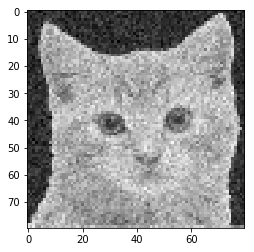

In [4]:
#######################################
# Write videos
#######################################

traces_lib.spikes2rateVideo(
    'rez/test1_lif_sol1_inp.avi',
    img1.shape,
    np.array(spikemon_inp.i),
    np.array(spikemon_inp.t),
    0,
    float(RUN_TIME),
    1000,
    0.1,
    maxRate=int(INPUT_FREQ_0+INPUT_FREQ_STIM))

traces_lib.spikes2rateVideo(
    'rez/test1_lif_sol1_lif.avi',
    img1.shape,
    np.array(spikemon_lif.i),
    np.array(spikemon_lif.t),
    0,
    float(RUN_TIME),
    1000,
    0.05,
    maxRate=150)


# Threshold trace
MaxThreshold = np.max(np.array(G_LIF.T))
traceT = (np.array(M.T) * 255 / MaxThreshold).astype(int)
with opencv_lib.cvWriter('rez/test1_lif_sol1_T.avi', img1.shape, codec='MJPG') as vid:
    for i in range(traceT.shape[1]):
        vid.write(traceT[:,i].reshape(img1.shape))

#Plot resulting threshold values
print("Average LIF firing rate is", len(spikemon_lif.i) / N_NEURON / RUN_TIME)
print("Min threshold after training is", np.min(np.array(G_LIF.T)))
print("Max threshold after training is", np.max(np.array(G_LIF.T)))
print("Average threshold after training is", np.average(np.array(G_LIF.T)))
plt.figure()
plt.imshow(np.array(G_LIF.T).reshape(img1.shape), cmap='gray')
plt.show()